## Import des librairies et chargement de la data

In [12]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
from sklearn.metrics import cohen_kappa_score

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\a\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\a\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\a\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Visualisation de la data 

In [13]:

data = pd.read_csv("data3classes.csv", encoding="latin-1")
data.head(5)

,Comment,Emotion
0,i seriously hate one subject to death but now ...,fear
1,im so full of life i feel appalled,anger
2,i sit here to write i start to dig out my feel...,fear
3,ive been really angry with r and i feel like a...,joy
4,i feel suspicious if there is no one outside l...,fear


<Axes: xlabel='Emotion', ylabel='count'>

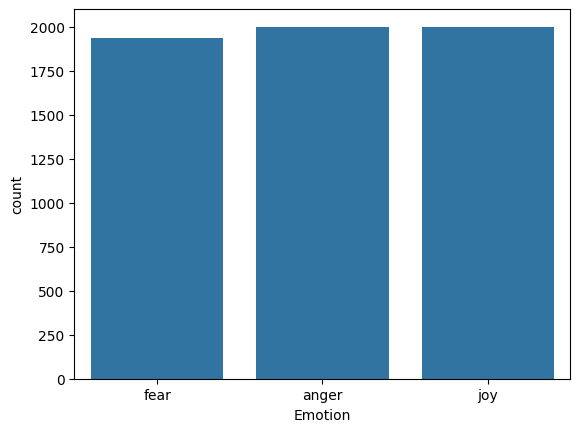

In [14]:
import seaborn as sns
sns.countplot(x='Emotion', data=data)

## Prétraitement

In [15]:
# Fonction de prétraitement
def preprocess_text(text):
    
    if isinstance(text, str):
       
        text = text.lower()
       
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        # Tokenization
        tokens = word_tokenize(text)
        # Supprimer les stopwords
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words]
        # Lemmatisation
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
       
        preprocessed_text = ' '.join(tokens)
        return preprocessed_text
    else:
        return ''


In [16]:

data['Sentence_Preprocessed'] = data['Comment'].apply(preprocess_text)

data_preprocessed = data[['Sentence_Preprocessed', 'Emotion']]


In [17]:

data_preprocessed.to_csv('data3classes2.csv', index=False)
# Afficher les cinq premières lignes
print(data_preprocessed.head(5))


                               Sentence_Preprocessed Emotion
0  seriously hate one subject death feel reluctan...    fear
1                         im full life feel appalled   anger
2  sit write start dig feeling think afraid accep...    fear
3  ive really angry r feel like idiot trusting fi...     joy
4  feel suspicious one outside like rapture happe...    fear


In [18]:

data = pd.read_csv('data3classes2.csv')


## Construction du modèle avec deux couches de LSTM

In [19]:

X = data['Sentence_Preprocessed']
y = pd.get_dummies(data['Emotion'])  # Convertir les labels en one-hot encoding


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenisation et vectorisation des données
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# Padding pour avoir des séquences de longueur égale
max_len = max(len(x) for x in X_train)
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=max_len)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_len)

# Construction du modèle LSTM
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=32))
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=3, activation='softmax'))  # Couche de sortie avec 3 neurones pour les 3 classes de sentiment
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

# Évaluation du modèle LSTM avec deux couches
loss_blstm, accuracy_blstm = model.evaluate(X_test, y_test)
print("LSTM with 2 layers Accuracy:", accuracy_blstm)

# Enregistrer le modèle dans le format natif Keras
model.save('emotion_classification_model.keras')

Epoch 1/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 17s 53ms/step - accuracy: 0.3898 - loss: 1.0517 - val_accuracy: 0.8931 - val_loss: 0.3209
Epoch 2/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9490 - loss: 0.1648 - val_accuracy: 0.9276 - val_loss: 0.2227
Epoch 3/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9900 - loss: 0.0397 - val_accuracy: 0.9217 - val_loss: 0.2514
Epoch 4/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9933 - loss: 0.0248 - val_accuracy: 0.9335 - val_loss: 0.2523
Epoch 5/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9974 - loss: 0.0134 - val_accuracy: 0.9251 - val_loss: 0.2715
Epoch 6/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9979 - loss: 0.0136 - val_accuracy: 0.9343 - val_loss: 0.2675
Epoch 7/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.9972 - loss: 0.0174 - val_accuracy: 0.9268 - val_loss: 0.2939
Epoch 8/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.9990 - loss: 0.0059 - val_acc